In [1]:
import optax
import json

import jax.numpy as np
import matplotlib.pyplot as plt

from jax import vmap, jit, hessian, grad
from xpinn import XPINN
from base_network import neural_network
from pathlib import Path
from utils import data_path, model_path
from type_util import Array

In [2]:
activation = np.tanh
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [3]:
data_path = data_path / "NavierStokes"
#file_train = data_path / "single_pinn_train_1500_5000.json"
file_test = data_path / "test.json"

xpinn = XPINN(file_test, activation)

In [4]:
our_model_path = model_path / "NavierStokes"/ "single_pinn"/ "laminar" / "ADAM_12000_JUNMAIO_x64_2100_small_2"#"ADAM_12000_JUNMAIO_x64_2100_2"#"Adam_20000_iter_7layer_model0"#f"ADAM_5000_JUNMAIO_x64_2000"

xpinn.load_model(our_model_path)

In [5]:
psi = lambda params, xy: model(params, xy)[0]
p = lambda params, xy: model(params, xy)[1]

hess_psi = hessian(psi, argnums=1)
d_psi_dxy = grad(psi, argnums=1)
def uv(params, xy):
    v_negated, u = d_psi_dxy(params, xy)
    return np.array([u, -v_negated])

uv = jit(vmap(uv, (None, 0)))
p = jit(vmap(p, (None, 0)))
j_model = jit(v_model)

In [6]:
def pinn_predict(params, args: dict[str, Array]):
    b = args["boundary"]
    i = args["interior"]
    if b.size == 0:
        points = i
    else:
        points = np.vstack([b, i])

    net_output = j_model(params, points)
    pressure = net_output[:, 1]
    #pressure = p(params, points)
    streamfunction = net_output[:, 0]
    flow = uv(params, points)
    flow_magnitude = np.sqrt(np.sum(flow**2, axis=1))

    return points, flow, flow_magnitude, pressure, streamfunction

In [7]:
def predict(input_file: str | Path = None):
    if input_file:
        main_args = {}
        with open(input_file) as infile:
            data = json.load(infile)

        for i, item in enumerate(data["XPINNs"]):
            interior = np.asarray(item["Internal points"])
            boundary = np.asarray(item["Boundary points"])

            main_args[i] = {"boundary": boundary, "interior": interior}

    else:
        main_args = xpinn.main_args

    total_streamfunction = []
    total_points = []
    total_flow = []
    total_p = []
    total_flow_magnitude = []


    for i, pinn in enumerate(xpinn.PINNs):
        params = pinn.params
        points, flow, flow_magnitude, p, streamfunction = pinn_predict(params, main_args[i])
        
        total_flow_magnitude.append(flow_magnitude)
        total_streamfunction.append(streamfunction)
        total_points.append(points)
        total_flow.append(flow)
        total_p.append(p)

    return total_points, total_flow, total_flow_magnitude, total_p, total_streamfunction

In [8]:
points, flow, flow_magitude, pressure, streamfunction = predict(file_test)

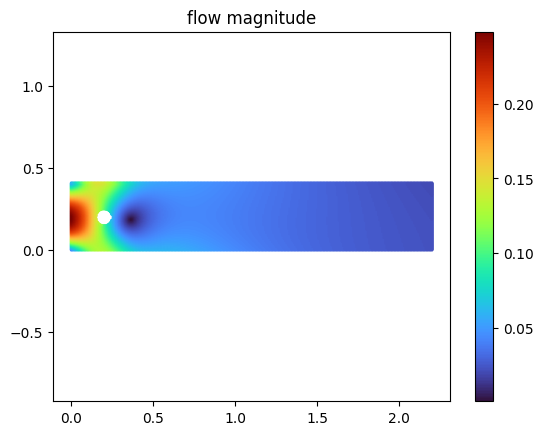

In [9]:
tot_flow_magnitude = np.concatenate(flow_magitude)
min_, max_ = tot_flow_magnitude.min(), tot_flow_magnitude.max()

for point, pred in zip(points, flow_magitude):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="Flow Magnitude", s=1)
plt.title("flow magnitude")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

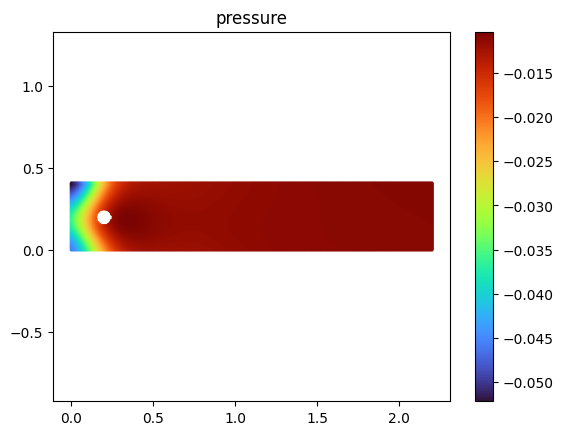

In [10]:
tot_pressure  =  np.concatenate(pressure)
min_, max_ = tot_pressure.min(), tot_pressure.max()

for point, pred in zip(points, pressure):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="pressure", s =1)
plt.title("pressure")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

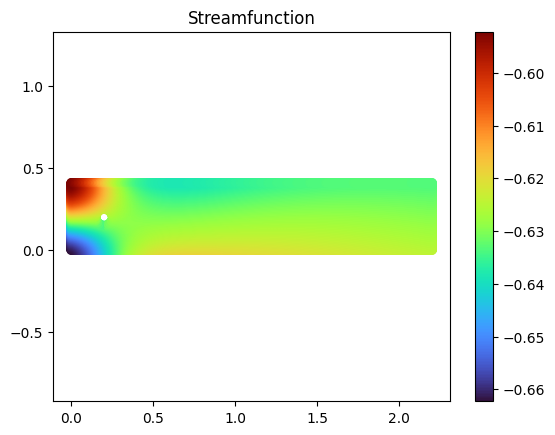

In [11]:
tot_streamfunction = np.concatenate(streamfunction)
in_, max_ = tot_streamfunction.min(), tot_streamfunction.max()


for point, pred in zip(points, streamfunction):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="streamfunction")
plt.title("Streamfunction")
#plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()